# Задача комивояжера. Поиск оптимального пути через все контрольные пункты на карте рогейна.

Реализован на карте рогейна "Тайные тропы" 2022 г.

## Загрузка данных

Данные загружаются из файла формата CSV.

In [1]:
# ячейка для подключения модулей python  и настроек отображения
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import seaborn as sns
from random import randint
from math import exp
from math import log
from tqdm import tqdm
from python_tsp.exact import solve_tsp_dynamic_programming
from python_tsp.heuristics import solve_tsp_simulated_annealing
from PIL import Image

pd.set_option("display.max_columns", None)
CLOSED_PATH = [[9,24],[24,9],
               [15,23],[23,15],
               [19,56],[56,19]]
# CLOSED_PATH = [[9,24],[24,9],
#                [15,23],[23,15],
#                [19,56],[56,19],
#                [22,23],[23,22],
#                [27,28],[28,27],
#                [27,30],[30,27],
#                [55,68],[68,55],
#                [56,68],[68,56],
#                [57,68],[68,57],
#                [59,63],[63,59],
#                [61,63],[63,61]]

In [2]:
# чтение файла CSV, в качестве разделителя использован символ табуляции
data = pd.read_csv('kp_tt_2022.csv', index_col='Name').drop('description', axis=1)
data.sort_index(inplace=True)
print(data.shape)
# вывод на экран первых 5 строк считанного файла
display(data)

(62, 2)


,X,Y
Name,,
0,50.034380,57.394896
21,50.047591,57.403483
31,50.003570,57.397244
32,50.013867,57.407098
33,50.049529,57.410424
...,...,...
103,50.200999,57.390875
104,50.170646,57.451284
105,50.087460,57.443265


### Формула вычисления Евклидова расстояния.
Вычисление евклидовых растояний между двумя точками.
+ Градус по X = 60,772 км
+ Градус по Y = 111.412 км

In [3]:
x_gr_km = 60.142
y_gr_km = 111.370202

def dist(x1,y1,x2,y2):

    delt_x = (x1 - x2)*x_gr_km
    delt_y = (y1 - y2)*y_gr_km
    evk_dist = (delt_x**2 + delt_y**2)**0.5
    
    return evk_dist

### Таблица расстояний

Создание таблицы расстояний.

In [4]:
%%time

index = list(data.index.values)
dict_array = []

for index_1, row_1 in data.iterrows():
    dict_dist = []
    for index_2, row_2 in data.iterrows():
        
        dict_dist.append(dist(row_1.loc['X'],
                              row_1.loc['Y'],
                              row_2.loc['X'],
                              row_2.loc['Y']))
    dict_array.append(np.array(dict_dist))
# массив numpy    
matrix_dist = np.array(dict_array)
# таблица pandas
distance_matrix = pd.DataFrame(matrix_dist, columns=data.index, index=data.index)

CPU times: total: 266 ms
Wall time: 276 ms


Таблица попарных расстояний.

In [5]:
distance_matrix

Name,0,21,31,32,33,34,41,42,43,44,45,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,91,92,93,94,95,96,101,102,103,104,105,106,200
Name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.000000,1.243353,1.871315,1.835368,1.954649,2.037662,1.285725,2.358434,2.884594,2.803685,6.841556,3.935160,3.703365,3.359310,4.411040,4.596473,5.145699,5.158269,6.574664,9.502087,3.427870,2.937934,2.831410,2.589794,3.892277,6.551421,8.491068,8.992225,9.773264,10.094057,1.498233,4.897987,5.392619,6.047603,5.708343,7.717563,7.689016,8.260010,6.764545,8.324715,4.811244,4.890407,7.674946,5.007225,6.999535,8.307081,8.728077,6.758399,10.290074,5.184695,7.685351,7.468904,9.695516,11.213603,10.115713,3.919479,9.787518,10.030851,10.324793,6.261730,11.434072,0.005100
21,1.243353,0.000000,2.737220,2.067824,0.781710,0.976248,1.424635,2.772911,3.680807,2.807337,6.395822,3.691615,2.460749,2.228284,3.466329,3.883050,4.716137,4.254047,5.904892,8.661309,4.643070,4.090076,2.042886,2.047952,3.793962,5.368556,7.933166,7.864209,8.576103,8.851696,2.735647,3.733578,4.152737,4.971138,4.859732,7.079256,6.548572,7.017733,6.324141,7.553469,5.952852,5.057532,7.320780,3.764529,6.082106,7.471318,7.491410,5.801207,9.681810,4.754237,6.772358,6.353632,8.990768,9.975576,8.937479,2.827522,8.667792,9.332523,9.116591,5.037735,10.710932,1.242421
31,1.871315,2.737220,0.000000,1.260141,3.129677,3.698965,3.144885,4.009789,4.098275,4.613111,8.705512,3.151002,4.915719,4.960716,6.173978,6.447740,7.012145,5.278678,6.156370,9.264553,2.456197,1.677088,3.158738,4.452106,5.701854,8.038000,7.795052,9.453013,10.475581,11.136506,1.858932,5.647311,6.654874,7.707137,7.524185,9.586459,9.256325,9.432210,5.969859,7.996093,3.378038,6.549720,9.520380,6.234142,8.786472,10.134180,9.971434,6.870556,9.619410,4.500842,7.658731,7.937728,9.202239,12.422743,11.596133,4.567490,11.384383,11.894980,11.712873,7.192038,10.930925,1.876075
32,1.835368,2.067824,1.260141,0.000000,2.176560,3.023104,3.021496,4.192927,4.631206,4.567012,8.425892,2.177430,3.847647,4.140158,5.491818,5.950775,6.733258,4.032550,5.053384,8.119377,3.709286,2.937221,1.910493,4.067602,5.637746,7.049545,6.830590,8.193422,9.221962,9.935045,2.663481,4.418217,5.565015,6.865113,6.908062,9.146259,8.311687,8.276955,5.047201,6.874363,4.586629,6.714367,9.321487,5.136432,8.095496,9.512997,8.839079,5.634388,8.650538,3.497805,6.451204,6.677601,8.149689,11.266328,10.572384,3.335651,10.446209,11.398642,10.635962,5.984514,9.889068,1.840200
33,1.954649,0.781710,3.129677,2.176560,0.000000,1.119284,2.154702,3.489144,4.450394,3.398141,6.644474,3.329851,1.814572,1.980536,3.390996,4.005436,5.011732,3.517255,5.251963,7.927569,5.253198,4.634340,1.440416,2.431219,4.299730,4.914713,7.316409,7.085094,7.821352,8.174661,3.450426,2.960315,3.550444,4.689149,4.830696,7.182809,6.154206,6.382420,5.780082,6.847504,6.463642,5.645405,7.613872,3.140589,5.960789,7.407875,6.888286,5.040140,9.034070,4.243012,6.020940,5.572793,8.305425,9.361118,8.467422,2.047256,8.287985,9.366287,8.588848,4.310641,10.013889,1.954771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,10.030851,9.332523,11.894980,11.398642,9.366287,8.379477,8.800029,8.455212,9.343440,7.570078,3.576096,12.589828,8.433973,7.448684,5.987249,5.460268,5.052486,11.375669,13.386791,14.685527,12.888782,12.726542,10.559340,7.442990,6.641347,6.171932,15.411802,11.738930,11.002927,9.289973,10.849072,9.593505,7.670571,5.296673,4.544081,2.338352,5.282984,7.984684,14.427557,14.211180,14.490728,6.849785,3.405017,7.923205,3.650718,2.175161,7.623883,11.997293,16.695493,13.155482,12.883466,11.062890,15.674761,8.680515,6.121028,9.894084,4.917689,0.000000,6.971021,8.981755,17.016348,10.026288
104,10.324793,9.116591,11.712873,10.635962,8.588848,8.310130,9.659399,

### Фнкция нахождения расстояния через все КП с заданным порядком.

In [6]:
def dist_all_point(data_point):
    data_iter_1 = data_point.iterrows()
    data_iter_2 = data_point.iterrows()
    next(data_iter_2)
    next_iteration = True
    all_dist = 0

    while next_iteration:
        point_1 = next(data_iter_1)
        point_2 = next(data_iter_2)

        all_dist += dist(point_1[1].loc['X'], point_1[1].loc['Y'], point_2[1].loc['X'], point_2[1].loc['Y'])

        next_iteration = point_2[0] != 200

    return all_dist

### Функция проверки вхождения закрытых переходов CLOSED_PATH.
Для самостоятельной реализации отжига.

### Функция изменение порядка взятия КП.

Для самостоятельной реализации отжига.

Перестановка между двумя случайными КП.

### Реализация жадного алгоритма

### Самостоятельная реализация отжига

### Полный перебор на библиотеке python_tsp

### Отжиг на библиотеке python_tsp

In [7]:
%%time

best_data = None
best_distance = 400
for _ in tqdm(range(30)):

    # 'index_i' - порядковый индекс, не 'Name'
    index_i, distance = solve_tsp_simulated_annealing(distance_matrix.values)
    # проверка, если последний индекс не в конце 61(200), переставить его в конец
    if index_i[len(index_i)-1] != len(index_i)-1:
        for i in index_i:
            if index_i[i] == len(index_i)-1:
                index_i.insert(len(index_i)-1,index_i.pop(i))

    # пересортировка изначального датасета, согласно решения index_i
    data.sort_index(inplace=True)
    data_index = data.reset_index()
    df=pd.DataFrame(data=None, index=index_i)
    data_new = pd.merge(df,data_index, left_index=True, right_index=True, sort=False).set_index('Name')
    distance = dist_all_point(data_new)
    
    if distance < best_distance:
        
        best_data = data_new
        best_distance = distance
        print(dist_all_point(data_new))
        print(data_new.index)

data = best_data
print(data.index)
print(dist_all_point(data))

  3%|██▊                                                                                | 1/30 [00:01<00:29,  1.02s/it]

100.59431598715675
Int64Index([  0,  31,  61,  80,  60,  70,  43,  42,  41,  44,  64,  63,  54,
             55,  56,  81,  82,  45,  75, 103,  85,  84,  74,  73,  65,  72,
            105,  77,  86,  76, 102,  96, 104,  95,  69,  68,  67,  93,  87,
             92,  59, 106,  88,  94,  66,  79,  58,  78,  91,  51,  32,  62,
            101,  57,  71,  83,  52,  53,  34,  33,  21, 200],
           dtype='int64', name='Name')


  7%|█████▌                                                                             | 2/30 [00:02<00:37,  1.33s/it]

97.96860749170176
Int64Index([  0,  41,  63,  34,  21,  33, 101,  71,  57,  62,  32,  31,  61,
             60,  80,  51,  91,  58,  78,  66,  88, 106,  94,  59,  79,  92,
             87,  93,  67,  68,  69,  95, 104,  96, 102,  86,  77, 105,  72,
             83,  52,  53,  54,  55,  74,  73,  65,  76,  84,  85, 103,  75,
             82,  45,  56,  81,  64,  44,  42,  43,  70, 200],
           dtype='int64', name='Name')


 27%|██████████████████████▏                                                            | 8/30 [00:11<00:31,  1.45s/it]

96.94250231541636
Int64Index([  0,  70,  60,  80,  61,  31,  32,  21,  33,  62,  51,  91,  58,
             78,  66,  94,  88, 106,  59,  79,  92,  87,  93,  67,  68,  69,
             77,  86,  95, 104,  96, 102,  76,  73,  65,  72,  83, 105,  71,
             57, 101,  52,  53,  54,  55,  56,  74,  84,  85, 103,  75,  45,
             82,  81,  64,  43,  42,  44,  63,  34,  41, 200],
           dtype='int64', name='Name')


 60%|█████████████████████████████████████████████████▏                                | 18/30 [00:28<00:20,  1.71s/it]

96.19756268002381
Int64Index([  0,  70,  60,  80,  61,  31,  32,  21,  33,  34,  53,  54,  55,
             74,  73,  65,  76,  86,  77, 105,  72,  83,  52,  71,  57, 101,
             62,  51,  91,  58,  78,  66,  94,  88, 106,  59,  79,  92,  87,
             93,  67,  68,  69,  95, 104,  96, 102,  84,  85, 103,  75,  82,
             45,  56,  64,  81,  43,  42,  44,  63,  41, 200],
           dtype='int64', name='Name')


 67%|██████████████████████████████████████████████████████▋                           | 20/30 [00:32<00:18,  1.89s/it]

95.9020452132094
Int64Index([  0,  41,  21,  33,  34,  63,  53,  52,  83,  72, 105,  71, 101,
             62,  51,  91,  58,  78,  66,  94,  88, 106,  59,  79,  92,  87,
             57,  93,  67,  68,  69,  77,  86,  95, 104,  96, 102,  76,  65,
             73,  84,  85, 103,  82,  45,  75,  74,  54,  55,  56,  81,  64,
             44,  42,  43,  70,  60,  80,  61,  31,  32, 200],
           dtype='int64', name='Name')


 77%|██████████████████████████████████████████████████████████████▊                   | 23/30 [00:36<00:10,  1.55s/it]

94.37801789445359
Int64Index([  0,  70,  60,  80,  61,  31,  32,  51,  91,  58,  78,  66,  88,
            106,  94,  59,  79,  92,  87,  57,  62, 101,  71, 105,  93,  67,
             68,  77,  86,  69,  95, 104,  96, 102,  76,  65,  72,  83,  52,
             53,  54,  55,  74,  73,  84,  85, 103,  75,  82,  45,  56,  81,
             64,  44,  42,  43,  41,  63,  34,  33,  21, 200],
           dtype='int64', name='Name')


100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:46<00:00,  1.55s/it]

Int64Index([  0,  70,  60,  80,  61,  31,  32,  51,  91,  58,  78,  66,  88,
            106,  94,  59,  79,  92,  87,  57,  62, 101,  71, 105,  93,  67,
             68,  77,  86,  69,  95, 104,  96, 102,  76,  65,  72,  83,  52,
             53,  54,  55,  74,  73,  84,  85, 103,  75,  82,  45,  56,  81,
             64,  44,  42,  43,  41,  63,  34,  33,  21, 200],
           dtype='int64', name='Name')
94.37801789445359
CPU times: total: 46.7 s
Wall time: 46.6 s


### Визуализации

#### Оптимальный маршрут по прямой

In [8]:
karta = np.asarray(Image.open('karta.jpg'))

In [9]:
data['X_reshape']=(data['X'] - data['X'].min())*4750+70
data['Y_reshape']=1255-(data['Y'] - data['Y'].min())*8800

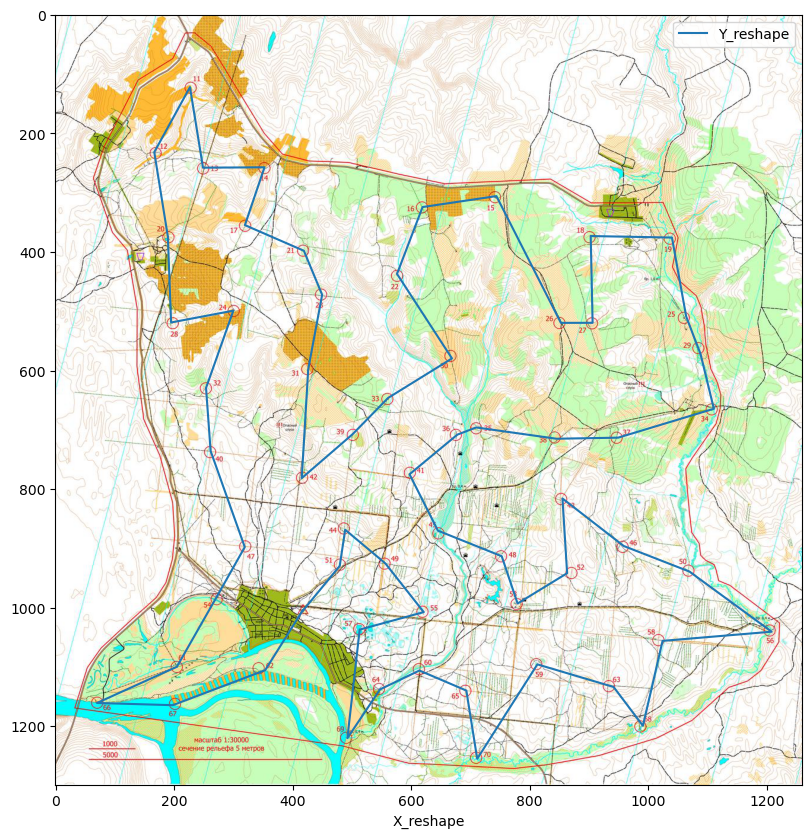

In [10]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1,1,1)
ax.imshow(karta)
data.plot(x='X_reshape',y='Y_reshape', ax=ax)
plt.show()

#### Плотность распределения контрольных пунктов на карте

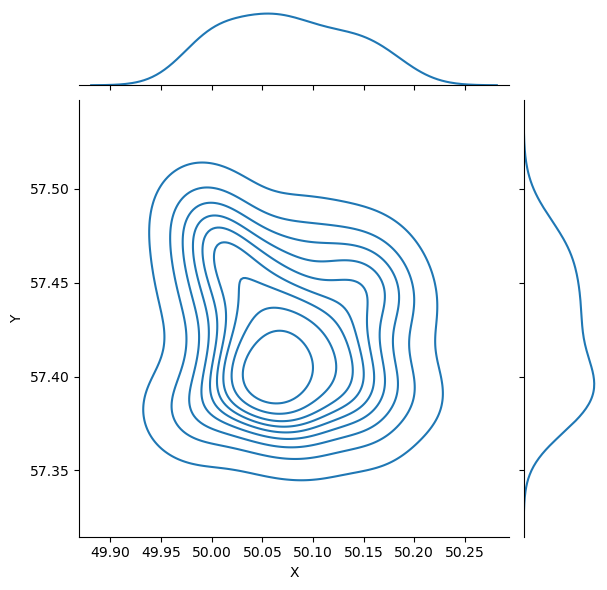

In [11]:
sns.jointplot(x="X", y="Y",
                data=data,
             kind="kde")
plt.show()

In [12]:
print(f'Наименьшая расчётная дистанция по прямой - {dist_all_point(data)}')

Наименьшая расчётная дистанция по прямой - 94.37801789445359


In [13]:
data.index

Int64Index([  0,  70,  60,  80,  61,  31,  32,  51,  91,  58,  78,  66,  88,
            106,  94,  59,  79,  92,  87,  57,  62, 101,  71, 105,  93,  67,
             68,  77,  86,  69,  95, 104,  96, 102,  76,  65,  72,  83,  52,
             53,  54,  55,  74,  73,  84,  85, 103,  75,  82,  45,  56,  81,
             64,  44,  42,  43,  41,  63,  34,  33,  21, 200],
           dtype='int64', name='Name')